# ECFPs 的从零实现
以丁酰胺 (Butyramide) 为例

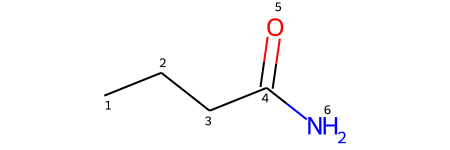

In [1]:
from rdkit import Chem


def show_atom_number(mol, label):
    for atom in mol.GetAtoms():
        atom.SetProp(label, str(atom.GetIdx() + 1))
    return mol


smi = 'CCCC(=O)N'
mol = Chem.MolFromSmiles(smi)
show_atom_number(mol, 'atomNote')

## Step 1 - Assigning an integer identifier to each atom
给每个原子分配一个整型标识符，标识符是根据以下7个属性组成的元组经过 hash 后获得的。
Daylight atomic invariants 是分子中原子的六个属性，分别是：
- 非氢邻接原子的个数 (Number of non-hydrogen immediate neighbors)
- 价电子数减去连接的氢原子的个数 (Valency minus the number of connected hydrogens)
- 原子序数 (Atomic number)
- 原子质量 (Atomic mass)
- 原子电荷 (Atomic charge)
- 连接的氢原子的个数 (Number of attached hydrogens (both implicit and explicit))

在 ECFP 特征中还包含一个属性：
- 该原子是否在环上，是为1否为0 (Whether the atom is a part of at least one ring(1, if yes, 0 otherwise))

这里以丁酰胺4位的碳原子为例，7个属性值分别为：
- 非氢邻接原子的个数 = 3
- 价电子数减去连接的氢原子的个数 = 4 (4-0)
- 原子序数 = 6
- 原子质量 = 12
- 原子电荷 = 0
- 连接的氢原子的个数 = 0
- 该原子是否在环上 = 0 (no)

因此，4位碳原子对应的属性元组为 f<sub>4</sub> = (3, 4, 6, 12, 0, 0, 0)
对 f<sub>4</sub> 应用 hash 函数后得到的即为该原子的初始化标识符

In [2]:
def generate_invariants(mol) -> dict:
    """Generate atomic invariants for each atom in a molecule."""
    invariants_for_each_atom = {}  # {atom_idx: invariants_tuple}
    for a in mol.GetAtoms():
        f1 = a.GetDegree()
        f2 = a.GetExplicitValence()
        f3 = a.GetAtomicNum()
        f4 = a.GetMass()
        f5 = a.GetFormalCharge()
        f6 = a.GetTotalDegree() - a.GetDegree()
        f7 = 1 if a.IsInRing() else 0
        invariants = (f1, f2, f3, f4, f5, f6, f7)
        invariants_for_each_atom[a.GetIdx() + 1] = invariants
    return invariants_for_each_atom


invariants = generate_invariants(mol)
invariants

{1: (1, 1, 6, 12.011, 0, 3, 0),
 2: (2, 2, 6, 12.011, 0, 2, 0),
 3: (2, 2, 6, 12.011, 0, 2, 0),
 4: (3, 4, 6, 12.011, 0, 0, 0),
 5: (1, 2, 8, 15.999, 0, 0, 0),
 6: (1, 1, 7, 14.007, 0, 2, 0)}

In [3]:
def generate_identifier(invariants: dict) -> dict:
    """Generate identifier for each atom in a molecule."""
    identifier_for_each_atom = {}  # {atom_idx: identifier}
    for idx, val in invariants.items():
        identifier_for_each_atom[idx] = hash(val)
    return identifier_for_each_atom


identifier = generate_identifier(invariants)
identifier

{1: 7116688983129619674,
 2: 2344552756697499922,
 3: 2344552756697499922,
 4: 2528737177023612951,
 5: -6488562442254792908,
 6: 5357766901376560257}

## Step 2 - Iteratively updating the atom identifiers
迭代更新每个原子的标识符
首先，对每个原子生成一个初始数组列表，数组包含两个内容：
1. 迭代数
2. 初始化标识符

对于示例分子中4位碳来说，即为 `[(1, 2528737177023612951)]`

然后，我们向这个列表中添加邻接原子及连接键的数组信息，每个邻接原子及连接键的信息用一个二元数组表示，其内容分别为：
1. 键类型 （分别用1、2、3、4表示单键、双键、三键、芳香键）
2. 邻接原子标识符

例如，丁酰胺中的4位碳将分别添加5位、3位和6位原子的信息，获得一个具有4个数组的列表

Note: GetBondTypeAsDouble() Returns the type of the bond as a double (i.e. 1.0 for SINGLE, 1.5 for AROMATIC, 2.0 for DOUBLE)

In [4]:
def neighbor_feature(mol, atom, identifier: dict) -> list:
    """Capture the chemical information of each non-hydrogen neighbor."""
    bond_types, identifiers = [], []
    for neighbor in atom.GetNeighbors():
        bond_type = mol.GetBondBetweenAtoms(atom.GetIdx(), neighbor.GetIdx()).GetBondTypeAsDouble()
        bond_types.append(bond_type)
        identifiers.append(identifier.get(neighbor.GetIdx() + 1))
    neighbor_features = list(zip(bond_types, identifiers))
    return neighbor_features


# 4位碳原子邻接原子的信息
neighbor_feature(mol, mol.GetAtomWithIdx(3), identifier)

[(1.0, 2344552756697499922),
 (2.0, -6488562442254792908),
 (1.0, 5357766901376560257)]

In [5]:
def update_identifier(mol, identifier: dict, iteration_number: int) -> dict:
    updated_identifier = {}
    for idx, val in identifier.items():
        f = [(iteration_number, val)] + neighbor_feature(mol, mol.GetAtomWithIdx(idx - 1), identifier)
        tuple_f = ()
        for i in f:
            tuple_f += i
        updated_identifier[idx] = hash(tuple_f)
    return updated_identifier


update_identifier(mol, identifier, 1)

{1: 4621612430120006443,
 2: 203667645206468003,
 3: -5197499935900455419,
 4: -3630734120408554432,
 5: 3563765881045461818,
 6: 2735465057684242944}

2位与3位原子初始的标识符是一样的，在一次迭代之后以及不一样了，因为他们各自所处的化学环境不同。

## Step 3 - Removing duplicate structures
将初始以及迭代后获得的标识符全部收集起来，然后去掉重复值

## Step 4 - Converting the identifiers to a bit vector
自定义一个 bit vector 长度，一般是1024。完成指定次数的迭代后，初始化一个全零的1024维度的向量，用获得的标识符除以1024取余，把向量中索引等于这些余数的位置的值设为1，即得到 ECFP

In [6]:
def identifier2list(identifier: dict) -> list:
    """Collect values in dictionary into a list."""
    identifier_ls = []
    for v in identifier.values():
        identifier_ls.append(v)
    return identifier_ls

In [7]:
import numpy as np


def ecfp(mol, radius=2, size=1024):
    identifier_collector = []
    # initial assignment stage
    invariants = generate_invariants(mol)
    identifier = generate_identifier(invariants)  # iteration0
    identifier_collector += identifier2list(identifier)
    # iterative updating stage
    for n in range(radius):
        identifier = update_identifier(mol, identifier, iteration_number=n + 1)
        identifier_collector += identifier2list(identifier)
    # duplicate identifier removal stage
    identifier_collector = set(identifier_collector)
    # forming the bit vector
    fill_one_idx = set()
    for i in identifier_collector:
        fill_one_idx.add(i % size)
    bit_vector = np.zeros(1024)
    bit_vector[list(fill_one_idx)] = 1
    return bit_vector


ecfp(mol)

array([0., 0., 0., ..., 0., 0., 0.])

# ECFPs 的简洁实现

In [8]:
from rdkit import Chem
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray
import numpy as np

atorvastatin_smiles = 'O=C(O)C[C@H](O)C[C@H](O)CCn2c(c(c(c2c1ccc(F)cc1)c3ccccc3)C(=O)Nc4ccccc4)C(C)C'
atorvastatin = Chem.MolFromSmiles(atorvastatin_smiles)  # Atorvastatin (aka Lipitor) is one of the world's best-selling drugs.

fingerprint = GetMorganFingerprintAsBitVect(atorvastatin, radius=2, nBits=2048)

fp_array = np.zeros((1,))
ConvertToNumpyArray(fingerprint, fp_array)

print(fp_array)

print(fp_array.shape)


[0. 1. 0. ... 0. 0. 0.]
(2048,)


# 使用 TorchDrug 实现 ECFPs

TorchDrug 中的 ECFP 默认半径为2，长度为 1024

In [9]:
from torchdrug import data

ecfp = data.feature.ExtendedConnectivityFingerprint(mol)
print(len(ecfp))
ecfp

1024


[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


# 使用 DeepChem 实现 ECFPs
每个分子被表示成一个 1024 维度的向量，向量中只有 0 和 1 两个数字

In [10]:
import deepchem as dc

feat = dc.feat.CircularFingerprint(size=1024)
arr = feat.featurize(mol)
arr

15:59:21   NumExpr defaulting to 8 threads.
15:59:24   Featurizing datapoint 0


array([[0., 0., 0., ..., 0., 0., 0.]])

数据集中的示例

In [11]:
tasks, datasets, transformers = dc.molnet.load_delaney(featurizer='ECFP')
train_dataset, valid_dataset, test_dataset = datasets

15:59:24   About to featurize delaney dataset.
15:59:25   Loading raw samples now.
15:59:25   shard_size: 8192
15:59:25   About to start loading CSV from /var/folders/3c/v18vsqt50jzgnmgzv858z_rm0000gn/T/delaney-processed.csv
15:59:25   Loading shard 1 of size 8192.
15:59:25   About to featurize shard.
15:59:25   Featurizing datapoint 0
15:59:27   Featurizing datapoint 1000
15:59:27   TIMING: featurizing shard 0 took 1.742 s
15:59:27   TIMING: dataset construction took 1.788 s
15:59:27   Loading dataset from disk.
15:59:27   About to split dataset with ScaffoldSplitter splitter.
15:59:27   Computing train/valid/test indices
15:59:27   About to generate scaffolds
15:59:27   Generating scaffold 0/1128
15:59:27   Generating scaffold 1000/1128
15:59:27   About to sort in scaffold sets
15:59:27   Constructing selection output shard 1
15:59:27   Selecting from input shard 1/1 for selection output shard 1
15:59:27   TIMING: dataset construction took 0.035 s
15:59:27   Loading dataset from disk

In [12]:
train_dataset

<DiskDataset X.shape: (902, 1024), y.shape: (902, 1), w.shape: (902, 1), ids: ['CC(C)=CCCC(C)=CC(=O)' 'CCCC=C' 'CCCCCCCCCCCCCC' ...
 'Nc2cccc3nc1ccccc1cc23 ' 'C1CCCCCC1' 'OC1CCCCCC1'], task_names: ['measured log solubility in mols per litre']>

In [13]:
train_dataset.X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])